<a href="https://www.kaggle.com/code/hardikksankhla/cnn-plastic-waste-classification?scriptVersionId=221280173" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Waste Classification using CNN

#### This notebook trains a Convolutional Neural Network (CNN) to classify different types of waste.
#### The dataset is loaded, preprocessed, and fed into the model for training.
#### We also implement techniques like , batch normalization, and early stopping to optimize performance.

## Plastic Waste Classification using CNN


#### *  This notebook implements a Convolutional Neural Network (CNN) to classify plastic waste.
#### *  It includes dataset loading, preprocessing, data augmentation, model training, and evaluation.
#### *  The model is optimized using batch normalization, early stopping to optimize performance, and dropout.



In [25]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10683.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10736.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10489.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10512.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10975.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10064.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10281.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10384.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10986.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10870.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10786.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10268.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10760.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10759.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_11008

# Import necessary libraries

### In this step, we import essential libraries required for:
#### - Data manipulation (NumPy, Pandas)
#### - Image processing (OpenCV, Matplotlib)
#### - Deep learning (TensorFlow/Keras)
#### - Performance monitoring (tqdm for progress tracking)


In [26]:
# Import necessary libraries
"""
We begin by importing essential libraries for:
- Data processing (NumPy, Pandas)
- Image handling (OpenCV, Matplotlib)
- Deep learning (TensorFlow/Keras)
- Progress monitoring (tqdm)
- System operations (os)
"""
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Suppress warnings for clarity
import warnings
warnings.filterwarnings('ignore')

## Verify TensorFlow installation and GPU availability

#### Check the installed TensorFlow version and confirm if GPU is available for faster training.

In [27]:
# Verify TensorFlow installation and GPU availability
print("TensorFlow Version:", tf.__version__)
print("Is GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.18.0
Is GPU Available: []


# Define dataset paths

#### Here, we specify the paths for training and test datasets.
#### These directories contain images sorted into folders based on categories.


In [28]:
# Define dataset paths
"""
Specify the paths to the training and testing datasets.
"""
train_path = "/kaggle/input/waste-classification-data/DATASET/TRAIN"
test_path = "/kaggle/input/waste-classification-data/DATASET/TEST"

In [29]:
# Visualization
from cv2 import cvtColor
x_data = []
y_data = []
for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])
data = pd.DataFrame({'image': x_data, 'label': y_data})


100%|██████████| 12565/12565 [00:26<00:00, 470.50it/s]


In [30]:
data.shape


(22564, 2)

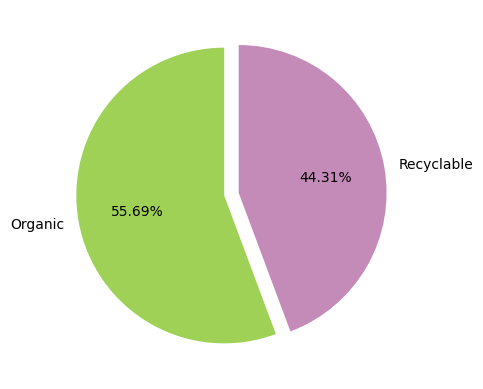

In [31]:
colors = ['#a0d157', '#c48bb8']
plt.pie(data.label.value_counts(), labels=['Organic', 'Recyclable'], autopct='%0.2f%%',
        colors=colors, startangle=90, explode=[0.05, 0.05])
plt.show()


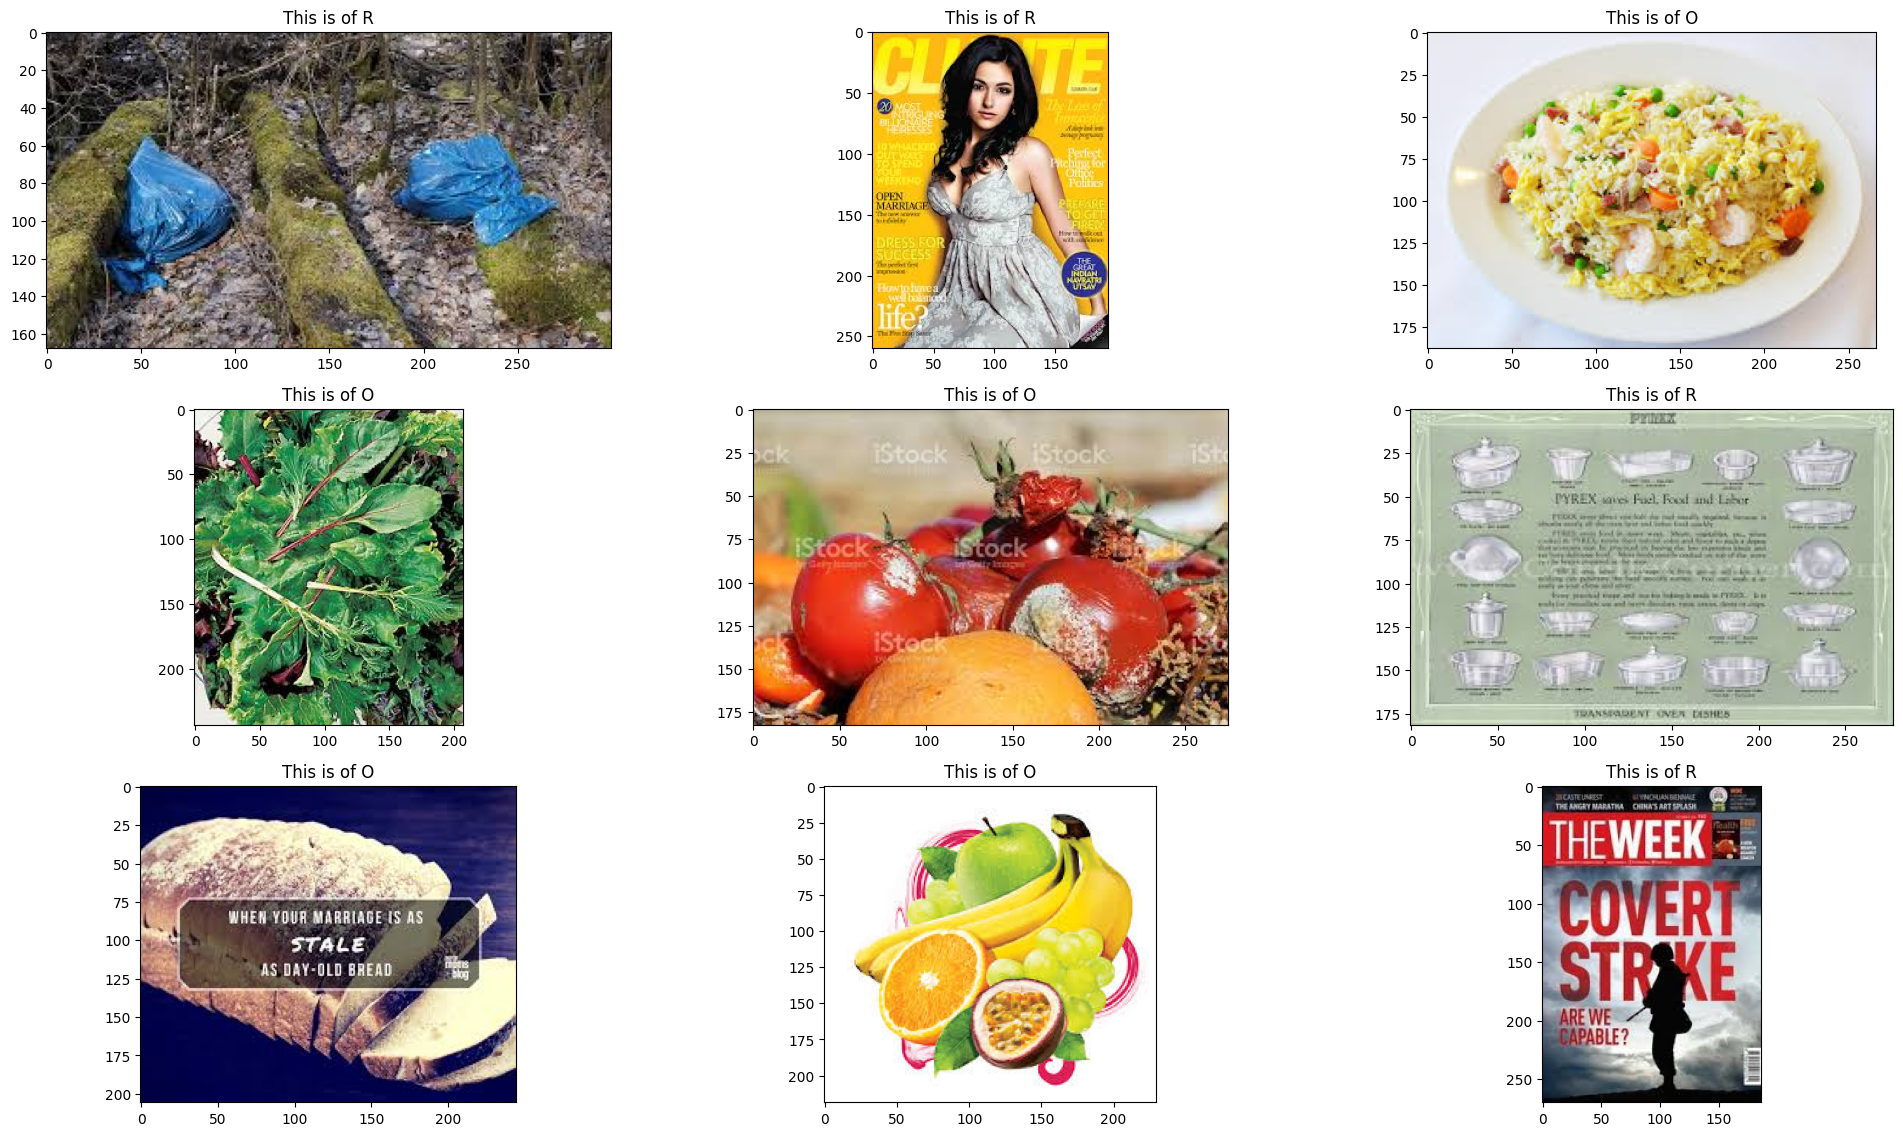

In [32]:
plt.figure(figsize=(20, 15))
for i in range(9):
    plt.subplot(4, 3,(i%12)+1)
    index = np.random.randint(15000)
    plt.title('This is of {0}'.format(data.label[index]))
    plt.imshow(data.image[index])
    plt.tight_layout()

# Data Augmentation to improve generalization

#### Data augmentation helps the model generalize better by applying transformations
#### such as rotation, zoom, and flipping to artificially increase dataset size.
#### We use `ImageDataGenerator` with:
#### - `rescale`: Normalize pixel values to [0,1]
#### - `rotation_range`: Randomly rotate images
#### - `width_shift_range` & `height_shift_range`: Shift images horizontally/vertically
#### - `shear_range` & `zoom_range`: Apply shear and zoom effects
#### - `horizontal_flip`: Flip images horizontally
#### - `fill_mode`: Fill missing pixels with nearest values
#### - `validation_split`: Split data into training and validation sets (80/20)


In [33]:
# Data Augmentation for better generalization
"""
We use `ImageDataGenerator` to apply transformations such as:
- Rotation, width/height shift, shear, zoom, and flipping
- Rescaling pixel values to [0,1]
- Splitting training data into training (80%) and validation (20%)
"""
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Load training and validation sets

#### We create training and validation generators using the augmented dataset.
#### - `target_size`: Resize images to 150x150 pixels
#### - `batch_size`: Set batch size to 32 for optimal training speed
#### - `class_mode`: Categorical classification for multiple classes
#### - `subset`: 'training' for training set and 'validation' for validation set


In [34]:
# Load training and validation data
"""
Generate training and validation datasets using augmentation.
Target size: 150x150 pixels, batch size: 32, class mode: categorical.
"""
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


# CNN - Convolutional Neural Network

* ## Define an optimized CNN model

#### We build a CNN model with:
#### 1. **Conv2D layers** for feature extraction
#### 2. **MaxPooling2D** for reducing spatial dimensions
#### 3. **BatchNormalization** for stable training
#### 4. **Flatten** to convert features into a dense layer
#### 5. **Dense layers** for learning complex patterns
#### 6. **Dropout (50%)** to prevent overfitting


In [35]:
#building a CNN model

def build_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(len(train_generator.class_indices), activation='softmax')
    ])
    return model

# Compile the CNN model

### Use Adam optimizer with a learning rate of 0.0001 for smooth training.
### Loss function: Categorical Crossentropy, suitable for multi-class classification.
### Metric: Accuracy.


In [36]:
# Compile the CNN model

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Display Model Summary

### View the architecture and parameter count of the compiled CNN model.


In [37]:
# Display Model Summary

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 74, 74, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,586 (72.61 MB)

 Trainable params: 19,035,138 (72.61 MB)

 Non-trainable params: 448 (1.75 KB)

# Implement early stopping and checkpointing

### - **EarlyStopping**: Stops training when validation loss stops improving.
### - **ModelCheckpoint**: Saves the best model during training.

In [40]:
# Implement early stopping and checkpointing

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)  # Updated file format
]


# Train the CNN model

### Train the model using 50 epochs and the augmented dataset.
### Monitor validation accuracy to prevent overfitting.


In [41]:
# Train the CNN model

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 724s 1s/step - accuracy: 0.7417 - loss: 1.2467 - val_accuracy: 0.6742 - val_loss: 0.8609
Epoch 2/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 777s 1s/step - accuracy: 0.7914 - loss: 0.6961 - val_accuracy: 0.7977 - val_loss: 0.5246
Epoch 3/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 728s 1s/step - accuracy: 0.8044 - loss: 0.5796 - val_accuracy: 0.7872 - val_loss: 0.5725
Epoch 4/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 747s 1s/step - accuracy: 0.8175 - loss: 0.5126 - val_accuracy: 0.8362 - val_loss: 0.4283
Epoch 5/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 746s 1s/step - accuracy: 0.8332 - loss: 0.4615 - val_accuracy: 0.7888 - val_loss: 0.5176
Epoch 6/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 727s 1s/step - accuracy: 0.8376 - loss: 0.4248 - val_accuracy: 0.8360 - val_loss: 0.4307
Epoch 7/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 769s 1s/step - accuracy: 0.8470 - loss: 0.3871 - val_accuracy: 0.8358 - val_loss: 0.3893
Epoch 8/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 726s 1s/step - accuracy: 0.8498 - loss: 0.3727 - val_accu

# Save the trained model
### Store the final trained model for future inference.

In [42]:
# Save the trained model

model.save("Waste-Classification-CNN-Model.h5")

# Plot training history

### Visualize training and validation performance using Matplotlib.
### - Accuracy curve shows model improvement.
### - Loss curve indicates model convergence.


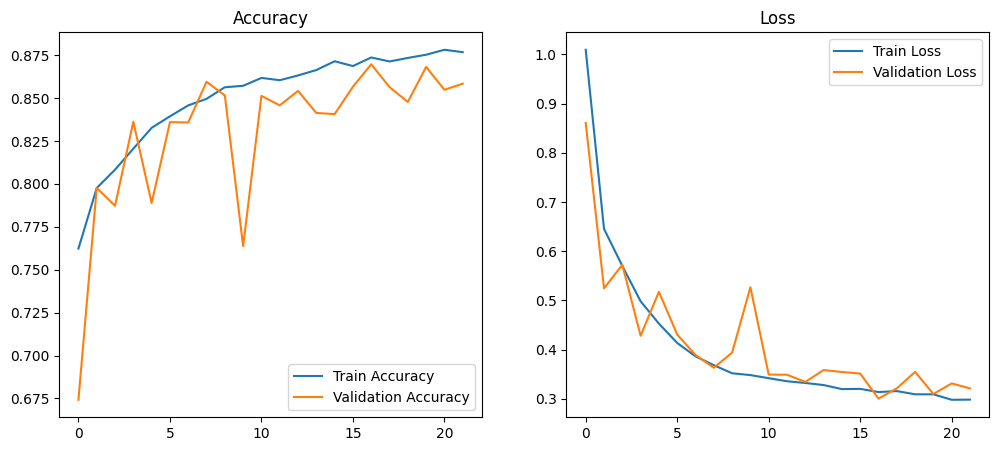

In [43]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

# Load the Trained Model

#### Now that our model is trained and saved, we load it back to perform predictions on new images.

In [50]:
# Load the Trained Model

from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model("Waste-Classification-CNN-Model.h5")

# Display the model architecture again to verify loading
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 74, 74, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,588 (72.62 MB)

 Trainable params: 19,035,138 (72.61 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

# Prepare Test Data

#### - Define the path to the test dataset.
#### - Create an image generator for rescaling.
#### - Load test images in a format similar to the training dataset.

In [51]:
# Prepare Test Data

test_path = "/kaggle/input/waste-classification-data/DATASET/TEST"

# Rescale test images to match training data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test dataset with similar preprocessing
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle so that labels remain aligned
)


Found 2513 images belonging to 2 classes.


# Evaluate Model Performance on Test Data

#### We check how well our model generalizes by testing it on unseen data.


In [52]:
# Evaluate model accuracy on test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 270ms/step - accuracy: 0.8602 - loss: 0.3855
Test Accuracy: 85.32%
Test Loss: 0.3997


# Make Predictions on Test Images

#### We will predict classes for test images and compare them with true labels.

In [53]:
# Make Predictions on Test Images

import numpy as np

# Get predictions (probabilities)
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get actual class labels from test generator
actual_classes = test_generator.classes

# Get class labels (to map indices back to names)
class_labels = list(test_generator.class_indices.keys())

# Print sample predictions
print("Predicted Classes:", [class_labels[i] for i in predicted_classes[:10]])
print("Actual Classes:", [class_labels[i] for i in actual_classes[:10]])


79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 370ms/step
Predicted Classes: ['O', 'O', 'O', 'O', 'R', 'O', 'O', 'O', 'O', 'O']
Actual Classes: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


# Visualize Predictions

#### We randomly select some test images and display them with predicted labels.

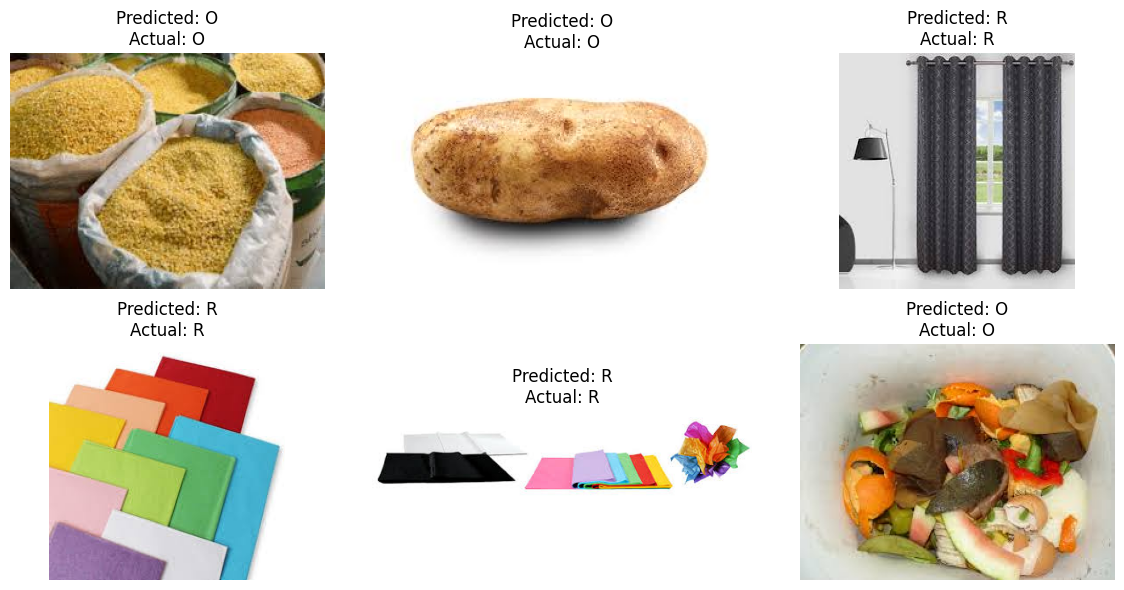

In [54]:
"""
# Visualize Some Test Images with Predictions
We randomly select some test images and display them with predicted labels.
"""
import matplotlib.pyplot as plt

# Get file names for test images
test_image_paths = test_generator.filepaths

# Select random indices
random_indices = np.random.choice(len(test_image_paths), 6, replace=False)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(random_indices):
    img = cv2.imread(test_image_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

    # Get predicted label
    predicted_label = class_labels[predicted_classes[idx]]
    actual_label = class_labels[actual_classes[idx]]

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}", fontsize=12)

plt.tight_layout()
plt.show()


# Classification Report & Confusion Matrix

#### This helps analyze model performance per class.

Classification Report:

              precision    recall  f1-score   support

           O       0.89      0.84      0.86      1401
           R       0.81      0.87      0.84      1112

    accuracy                           0.85      2513
   macro avg       0.85      0.86      0.85      2513
weighted avg       0.86      0.85      0.85      2513



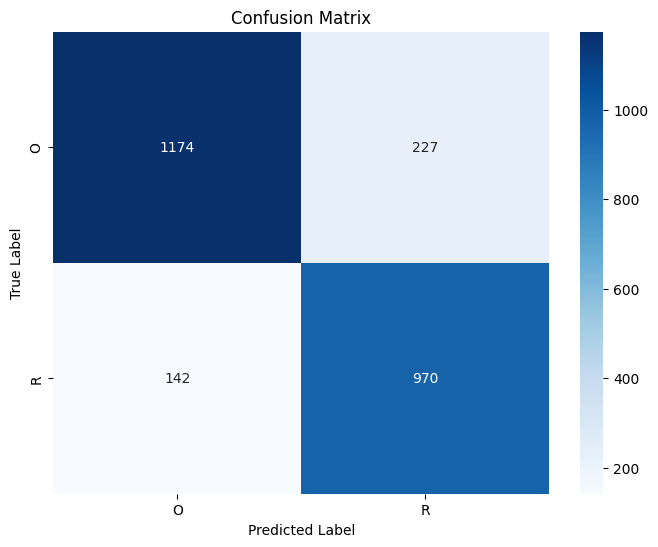

In [55]:
# Generate Classification Report and Confusion Matrix

from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print("Classification Report:\n")
print(classification_report(actual_classes, predicted_classes, target_names=class_labels))

# Generate and plot confusion matrix
import seaborn as sns

cm = confusion_matrix(actual_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
